Use horizontal flip. Note: small batch size!

Take sample of training dataset

Architecture from MS

### \\\ Currently used ///

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 4
multi_gpus = None#[0, 1, 2]
b = 6
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
train_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
holdout_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

In [9]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [10]:
#new_ind, _ = train_test_split(np.arange(len(X_train)), train_size=1.)
new_ind = np.arange(len(X_train))

In [11]:
print(len(new_ind))

697


In [12]:
train_sampler = SubsetRandomSampler(new_ind)

In [13]:
# convert data to numpy arrays
#X_train = np.array(X_train, dtype=dtype)
#y_train = np.array(y_train)

#X_holdout = np.array(X_holdout, dtype=dtype)
#y_holdout = np.array(y_holdout)

In [14]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        #if np.isnan(X).any() == True:
        #    print("removed nan")
        #    X[np.isnan(X)] = 0.
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
            
        sample = {"image" : image,
                 "label" : label}
                 #"idx":idx}
        return sample

In [15]:
if zero_one_normalize:
    intensity = IntensityRescale()
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose([SagittalFlip(), intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([SagittalFlip(), intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([SagittalFlip(), intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose([SagittalFlip(), ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([SagittalFlip(), ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([SagittalFlip(), ToTensor()]), mask=mask, dtype=dtype)

torch.Size([1, 96, 114, 96])


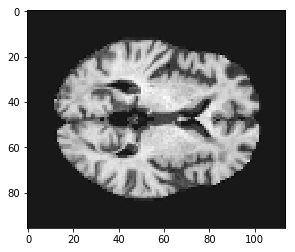

In [16]:
sample = adni_data_test[-1]
img = sample["image"]
print(img.shape)
plt.imshow(img[0][:,:,40], cmap='gray')

# Define the classifier

In [17]:
class PatchIndividualFilters3D(Module):
    def __init__(self, input_dim, filter_shape, patch_shape, num_local_filter_in, num_local_filter_out, debug=0):
        super(PatchIndividualFilters3D, self).__init__()
        self.input_dim = input_dim  # expects it to be a 3D vector
        self.filter_shape = filter_shape
        self.patch_shape = patch_shape
        self.num_local_filter_out = num_local_filter_out
        self.num_local_filter_in = num_local_filter_in

        # calc padding and num_patches
        self.padding_dim = [0] * len(self.input_dim) * 2
        # initialize all local convs with weight & co
        self.num_patches, self.num_patches_per_dim = self.calc_pad_dim_num_patches()

        self.conv_dict = {}
        for patch in range(self.num_patches):
            # initialize convolution object
            self.add_module("conv_{}".format(patch),
                            nn.Conv3d(self.num_local_filter_in, self.num_local_filter_out, self.filter_shape, stride=1))
            # initialize activation object
            self.add_module("activ_{}".format(patch),
                            nn.ELU())
            

        self.grads = {}
        self.debug = debug

    def save_grad(self, name):

        def hook(grad):
            self.grads[name] = grad

        return hook

    def calc_pad_dim_num_patches(self):
        # initialize
        num_patches = 1
        num_patches_per_dim = [0] * len(self.input_dim)

        # check if patch_shape fits input dimension
        for idx, dim in enumerate(self.patch_shape):
            tmp_remain = self.input_dim[idx] % dim
            tmp_division = self.input_dim[idx] // dim
            if tmp_remain != 0:
                # how much we need to add sch that patch_shape fits perfectly
                self.padding_dim[idx * 2] = dim - tmp_remain
                tmp_division += 1
            num_patches_per_dim[idx] = tmp_division
            num_patches = num_patches * tmp_division
        return num_patches, num_patches_per_dim

    def pad_to_batch_size(self, input):
        # expects input to be a 5D vector!

        # pad input
        if sum(self.padding_dim):
            # add batch and channel dimension, each twice, to padding dim
            pad_dim = [0, 0, 0, 0] + self.padding_dim

            # use constant pad (caution: last dimension first!)
            input = torch.nn.functional.pad(input, pad_dim[::-1], mode='constant', value=0)

        if self.debug:
            input.register_hook(self.save_grad("post_padding"))

        return input

    def split_5d(self, input):
        # get batch size of input
        bs = input.shape[0]
        # initialize
        splits = []
        # loop over batch and filter and split each "input"
        for batch in range(bs):
            splits_filter = []
            for filter in range(self.num_local_filter_in):
                feature_map_in = input[batch, filter]
                # get chunks back from feature map ("input")
                t = self.get_chunks(feature_map_in)
                # append chunk dimension
                t = [torch.unsqueeze(x, 0) for x in t]
                # cat along chunk dimension
                t = torch.cat(t, 0)
                # add to filter list
                splits_filter += [t]
            # append filter dimension
            splits_filter = [torch.unsqueeze(x, 0) for x in splits_filter]
            # cat along filter dimension
            splits_filter = torch.cat(splits_filter, 0)
            splits += [splits_filter]
        # append batch dimension
        splits = [torch.unsqueeze(x, 0) for x in splits]
        # finally cat along that dimension
        splits = torch.cat(splits, 0)

        if self.debug:
            input.register_hook(self.save_grad("post_reshape"))

        return splits, bs  # a 6D vector

    def get_chunks(self, ddd_input):
        ddd_input_shape = ddd_input.shape
        tns = [ddd_input]
        # for every dimension in 3d input we split according to dimension and number of desired patches
        for id, dim in enumerate(ddd_input_shape):
            tns_tmp = []
            for tnsr in tns:
                # determine how to split the tensor.
                # Example:
                # dimension is 4: 2 batches desired in that dimension -> split dimension in [2,2]
                # dimension is 4: 4 batches desired in that dimension -> split dimension in [1,1,1,1]
                dim_x_split_size = [int(dim / self.num_patches_per_dim[id])] * self.num_patches_per_dim[id]
                # print("dim: " + str(dim))
                # print("num_patches: " + str(self.num_patches_per_dim))
                # print("dim_split_size: " + str(dim_x_split_size))
                tmp = torch.split(tnsr, dim_x_split_size, id)
                tns_tmp += list(tmp)
            tns = tns_tmp
        return tns

    def call_conv(self, idx, patch):

        if self.debug:
            patch.register_hook(self.save_grad("pre_convol_{}".format(idx)))

        # apply convolution
        c_res = getattr(self, "conv_{}".format(idx))(patch)
        # apply activation
        c_res = getattr(self, "activ_{}".format(idx))(c_res)

        if self.debug:
            c_res.register_hook(self.save_grad("post_conv_{}".format(idx)))

        # add 6th dimension at 2. place for later cat
        c_res = c_res.unsqueeze(2)

        if self.debug:
            c_res.register_hook(self.save_grad("post_usqz_c_{}".format(idx)))

        return c_res

    def forward(self, input):

        # set hook to save gradient in debug mode
        if self.debug:
            input.register_hook(self.save_grad("backward_out"))

        # do reshape here!
        input = self.pad_to_batch_size(input)

        # reshape
        input, bs = self.split_5d(input)

        patch_out = []
        for idx in range(self.num_patches):
            # get patch
            patch = input[:, :, idx]  # get each patch (3nd Dimension of 6D vector)
            # do separate convolutions with each 5D vector!
            patch_out += [self.call_conv(idx, patch)]

        # concat to get 6D vector back
        out = torch.cat(patch_out, dim=2)

        # # put together
        # f_out = []
        # feature_out_dim = out.shape[-3:]
        # for filter in range(self.num_local_filter_out):
        #     filter_patch = []
        #     for patch in range(self.num_patches):
        #         y = out[patch, :, filter]
        #         filter_patch.append(y)
        #     z = torch.cat(filter_patch)
        #     z = z.view((bs,) + tuple([x * self.num_patches_per_dim[id] for id, x in enumerate(feature_out_dim)]))
        #     f_out.append(z)
        # out = torch.cat(f_out).unsqueeze(0)
        # out = out.view((bs, self.num_local_filter_out) + tuple([x * self.num_patches_per_dim[id] for id, x in enumerate(feature_out_dim)]))

        if self.debug:
            out.register_hook(self.save_grad("backward_in"))

        return out

In [18]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([10,13,10],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=3,
                                            debug=False)

        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            nn.Linear(972, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        #h = F.dropout3d(self.pool_4(x), p=self.drp_rate)
        #if print_size:
        #    print(h.shape)
    
        h = self.pif(x)
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [19]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [20]:
print(net)

SixtyFourNet(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pif): PatchIndividualFilters3D(
    (conv_0): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (activ_0): ELU(alpha=1.0)
    (conv_1): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (activ_1): ELU(alpha=1.0)
    (conv_2): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (activ_2): ELU(alpha=1.0)
    (conv_3): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (activ_3): ELU(alpha=1

In [21]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 493405


# Training

In [22]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        
        #sched = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=12)
        #sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=5)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [23]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy, auc_score]

In [24]:
r = 0

In [25]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),
callbacks = [EarlyStopping(patience=12, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]
#augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

Starting trial 0
torch.Size([1, 96, 114, 96])
117


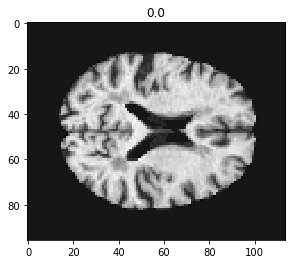

[0,    20] loss: 0.69832
[0,    40] loss: 0.69417
[0,    60] loss: 0.69616
[0,    80] loss: 0.69032
[0,   100] loss: 0.69077
Time elapsed: 0h:0m:57s
train accuracy_score: 50.07 %
train balanced_accuracy: 49.44 %
train auc_score: 49.44 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.688415
[1,    20] loss: 0.69457
[1,    40] loss: 0.69681
[1,    60] loss: 0.69134
[1,    80] loss: 0.69716
[1,   100] loss: 0.69397
Time elapsed: 0h:1m:56s
train accuracy_score: 51.36 %
train balanced_accuracy: 51.67 %
train auc_score: 51.67 %
val accuracy_score: 79.00 %
val balanced_accuracy: 77.92 %
val auc_score: 77.92 %
Val loss: 0.691594
[2,    20] loss: 0.68826
[2,    40] loss: 0.69648
[2,    60] loss: 0.69360
[2,    80] loss: 0.69354
[2,   100] loss: 0.69773
Time elapsed: 0h:2m:54s
train accuracy_score: 52.37 %
train balanced_accuracy: 51.71 %
train auc_score: 51.71 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val l

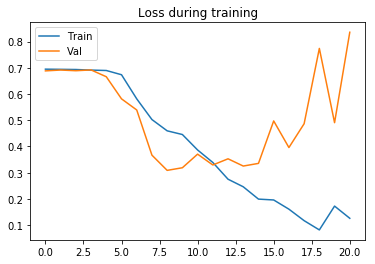

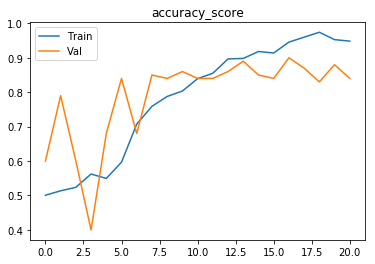

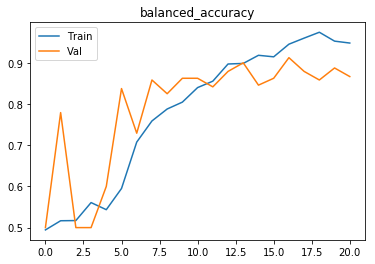

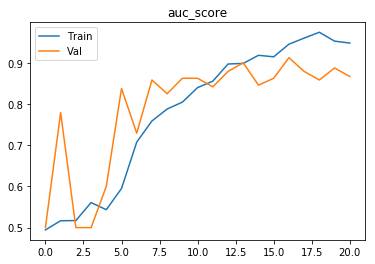

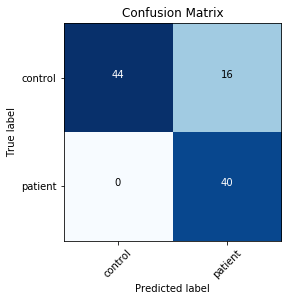

Starting trial 1
torch.Size([1, 96, 114, 96])
117


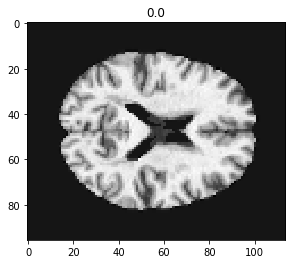

[0,    20] loss: 0.70086
[0,    40] loss: 0.69349
[0,    60] loss: 0.69455
[0,    80] loss: 0.69253
[0,   100] loss: 0.69470
Time elapsed: 0h:0m:55s
train accuracy_score: 50.65 %
train balanced_accuracy: 49.51 %
train auc_score: 49.51 %
val accuracy_score: 61.00 %
val balanced_accuracy: 51.25 %
val auc_score: 51.25 %
Val loss: 0.691523
[1,    20] loss: 0.69482
[1,    40] loss: 0.69230
[1,    60] loss: 0.69582
[1,    80] loss: 0.69010
[1,   100] loss: 0.69481
Time elapsed: 0h:1m:54s
train accuracy_score: 53.08 %
train balanced_accuracy: 52.83 %
train auc_score: 52.83 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701919
[2,    20] loss: 0.69267
[2,    40] loss: 0.69256
[2,    60] loss: 0.69026
[2,    80] loss: 0.68943
[2,   100] loss: 0.68493
Time elapsed: 0h:2m:54s
train accuracy_score: 52.80 %
train balanced_accuracy: 52.89 %
train auc_score: 52.89 %
val accuracy_score: 73.00 %
val balanced_accuracy: 76.67 %
val auc_score: 76.67 %
Val l

[24,    20] loss: 0.05734
[24,    40] loss: 0.03952
[24,    60] loss: 0.06522
[24,    80] loss: 0.05863
[24,   100] loss: 0.03394
Time elapsed: 0h:24m:51s
train accuracy_score: 98.28 %
train balanced_accuracy: 98.30 %
train auc_score: 98.30 %
val accuracy_score: 92.00 %
val balanced_accuracy: 93.33 %
val auc_score: 93.33 %
Val loss: 0.612355
Early stopping in epoch 25
Total time elapsed: 0h:24m:55s
Finished fold.


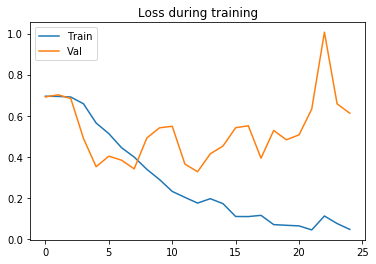

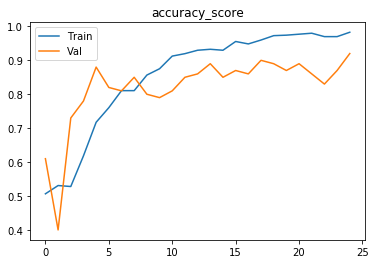

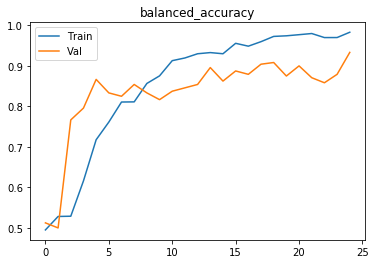

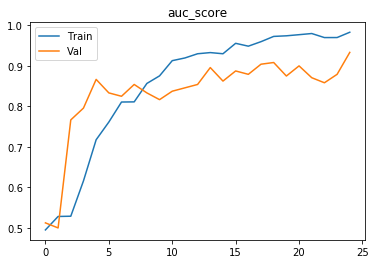

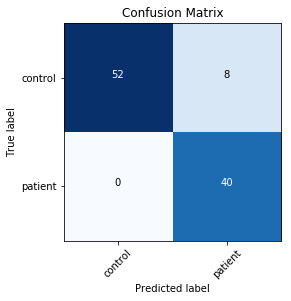

Starting trial 2
torch.Size([1, 96, 114, 96])
117


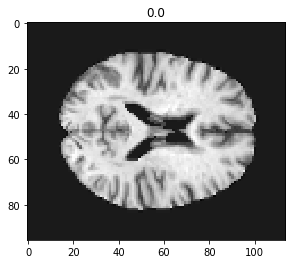

[0,    20] loss: 0.69878
[0,    40] loss: 0.69686
[0,    60] loss: 0.69136
[0,    80] loss: 0.69772
[0,   100] loss: 0.69602
Time elapsed: 0h:0m:55s
train accuracy_score: 48.21 %
train balanced_accuracy: 48.02 %
train auc_score: 48.02 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694517
[1,    20] loss: 0.69105
[1,    40] loss: 0.70014
[1,    60] loss: 0.69592
[1,    80] loss: 0.69460
[1,   100] loss: 0.69284
Time elapsed: 0h:1m:54s
train accuracy_score: 50.22 %
train balanced_accuracy: 49.79 %
train auc_score: 49.79 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.687840
[2,    20] loss: 0.68701
[2,    40] loss: 0.69753
[2,    60] loss: 0.70155
[2,    80] loss: 0.69185
[2,   100] loss: 0.69494
Time elapsed: 0h:2m:55s
train accuracy_score: 53.80 %
train balanced_accuracy: 53.79 %
train auc_score: 53.79 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val l

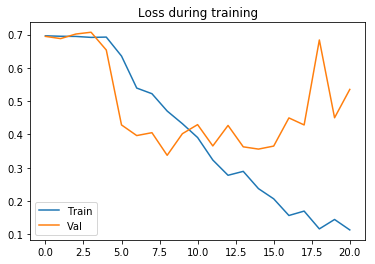

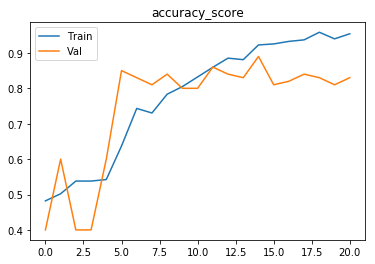

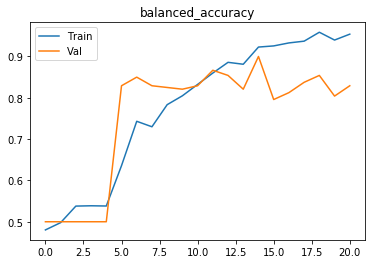

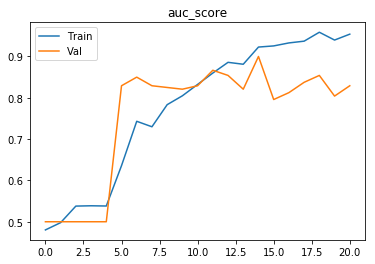

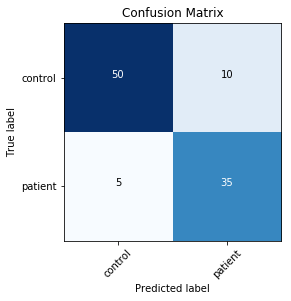

Starting trial 3
torch.Size([1, 96, 114, 96])
117


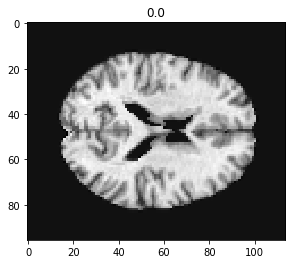

[0,    20] loss: 0.69383
[0,    40] loss: 0.69638
[0,    60] loss: 0.69429
[0,    80] loss: 0.68763
[0,   100] loss: 0.71843
Time elapsed: 0h:0m:56s
train accuracy_score: 53.08 %
train balanced_accuracy: 52.80 %
train auc_score: 52.80 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700001
[1,    20] loss: 0.69696
[1,    40] loss: 0.69519
[1,    60] loss: 0.69443
[1,    80] loss: 0.69511
[1,   100] loss: 0.69238
Time elapsed: 0h:1m:55s
train accuracy_score: 48.64 %
train balanced_accuracy: 48.22 %
train auc_score: 48.22 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700076
[2,    20] loss: 0.69391
[2,    40] loss: 0.69261
[2,    60] loss: 0.69330
[2,    80] loss: 0.69479
[2,   100] loss: 0.68933
Time elapsed: 0h:2m:56s
train accuracy_score: 51.65 %
train balanced_accuracy: 50.82 %
train auc_score: 50.82 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val l

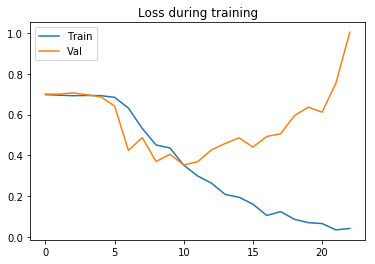

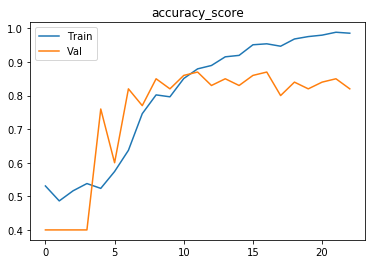

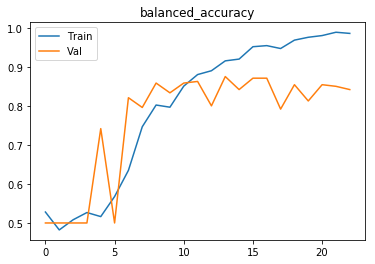

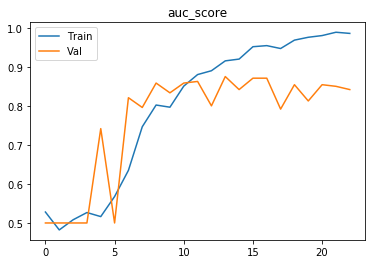

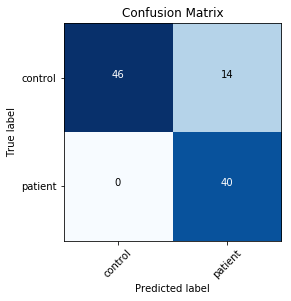

Starting trial 4
torch.Size([1, 96, 114, 96])
117


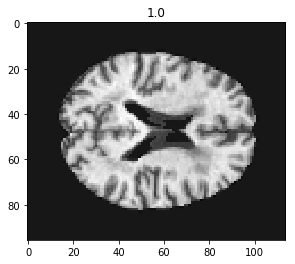

[0,    20] loss: 0.70134
[0,    40] loss: 0.69241
[0,    60] loss: 0.69532
[0,    80] loss: 0.69659
[0,   100] loss: 0.69228
Time elapsed: 0h:0m:58s
train accuracy_score: 49.78 %
train balanced_accuracy: 49.13 %
train auc_score: 49.13 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703287
[1,    20] loss: 0.69566
[1,    40] loss: 0.69228
[1,    60] loss: 0.69525
[1,    80] loss: 0.69677
[1,   100] loss: 0.68991
Time elapsed: 0h:2m:0s
train accuracy_score: 50.79 %
train balanced_accuracy: 49.97 %
train auc_score: 49.97 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.686206
[2,    20] loss: 0.69655
[2,    40] loss: 0.69125
[2,    60] loss: 0.69044
[2,    80] loss: 0.69393
[2,   100] loss: 0.68027
Time elapsed: 0h:3m:0s
train accuracy_score: 51.94 %
train balanced_accuracy: 51.55 %
train auc_score: 51.55 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val los

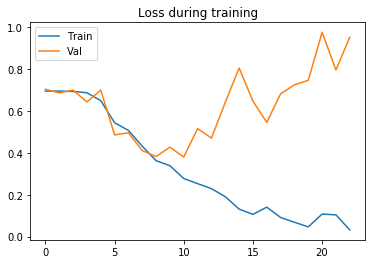

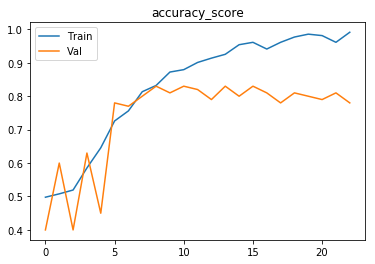

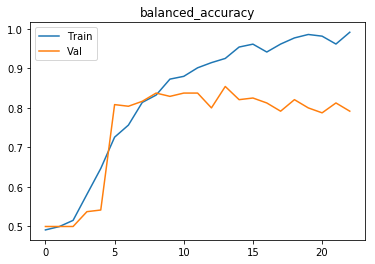

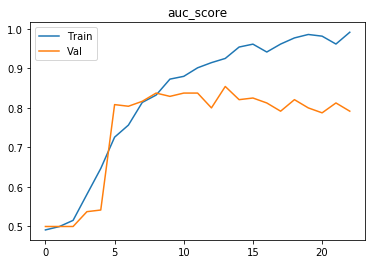

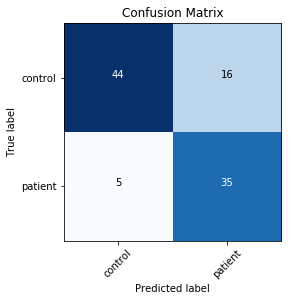

Starting trial 5
torch.Size([1, 96, 114, 96])
117


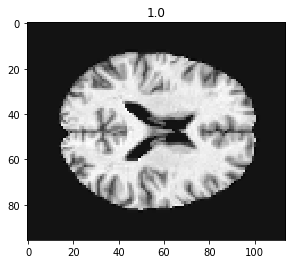

[0,    20] loss: 0.69374
[0,    40] loss: 0.69728
[0,    60] loss: 0.69578
[0,    80] loss: 0.69572
[0,   100] loss: 0.69341
Time elapsed: 0h:0m:57s
train accuracy_score: 47.06 %
train balanced_accuracy: 47.05 %
train auc_score: 47.05 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696433
[1,    20] loss: 0.69465
[1,    40] loss: 0.69644
[1,    60] loss: 0.69404
[1,    80] loss: 0.69231
[1,   100] loss: 0.69386
Time elapsed: 0h:1m:58s
train accuracy_score: 50.22 %
train balanced_accuracy: 49.40 %
train auc_score: 49.40 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693866
[2,    20] loss: 0.69310
[2,    40] loss: 0.68955
[2,    60] loss: 0.69153
[2,    80] loss: 0.69557
[2,   100] loss: 0.69351
Time elapsed: 0h:3m:0s
train accuracy_score: 52.22 %
train balanced_accuracy: 51.29 %
train auc_score: 51.29 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val lo

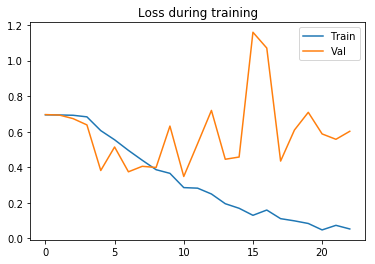

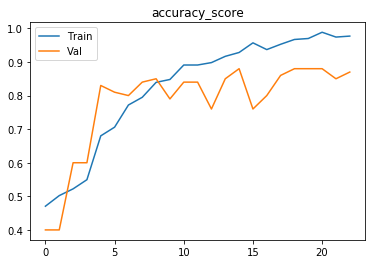

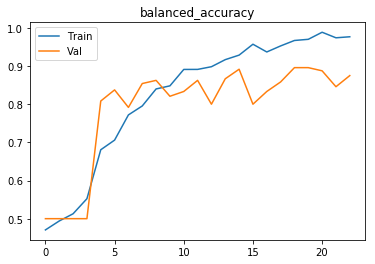

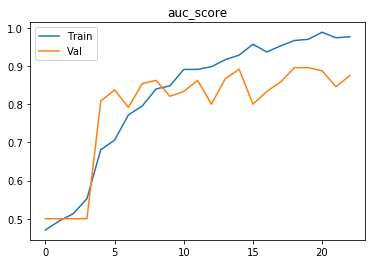

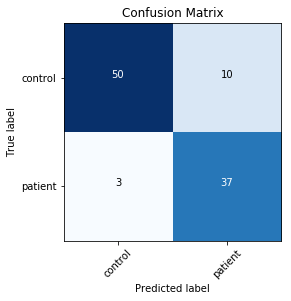

Starting trial 6
torch.Size([1, 96, 114, 96])
117


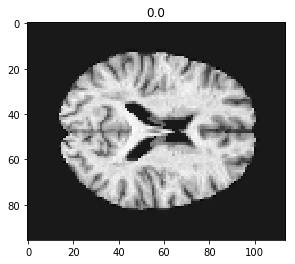

[0,    20] loss: 0.69696
[0,    40] loss: 0.69468
[0,    60] loss: 0.70201
[0,    80] loss: 0.69383
[0,   100] loss: 0.69661
Time elapsed: 0h:0m:55s
train accuracy_score: 48.78 %
train balanced_accuracy: 48.53 %
train auc_score: 48.53 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693520
[1,    20] loss: 0.69254
[1,    40] loss: 0.69466
[1,    60] loss: 0.69689
[1,    80] loss: 0.70043
[1,   100] loss: 0.68123
Time elapsed: 0h:1m:56s
train accuracy_score: 52.37 %
train balanced_accuracy: 52.20 %
train auc_score: 52.20 %
val accuracy_score: 61.00 %
val balanced_accuracy: 52.92 %
val auc_score: 52.92 %
Val loss: 0.691249
[2,    20] loss: 0.69359
[2,    40] loss: 0.69083
[2,    60] loss: 0.69217
[2,    80] loss: 0.69023
[2,   100] loss: 0.69380
Time elapsed: 0h:2m:55s
train accuracy_score: 52.65 %
train balanced_accuracy: 51.50 %
train auc_score: 51.50 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val l

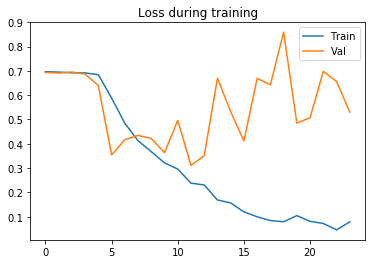

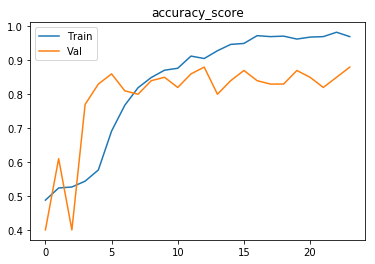

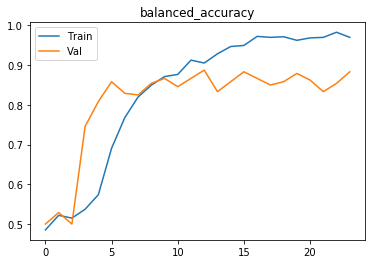

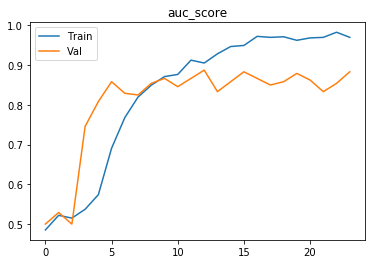

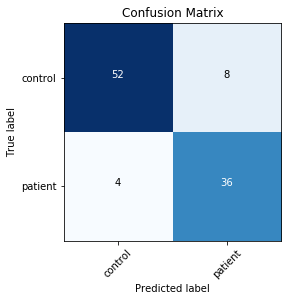

Starting trial 7
torch.Size([1, 96, 114, 96])
117


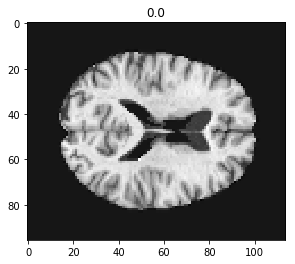

[0,    20] loss: 0.69119
[0,    40] loss: 0.68774
[0,    60] loss: 0.70496
[0,    80] loss: 0.69423
[0,   100] loss: 0.70271
Time elapsed: 0h:0m:57s
train accuracy_score: 53.80 %
train balanced_accuracy: 53.27 %
train auc_score: 53.27 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.677648
[1,    20] loss: 0.70663
[1,    40] loss: 0.69341
[1,    60] loss: 0.69733
[1,    80] loss: 0.69183
[1,   100] loss: 0.69257
Time elapsed: 0h:1m:58s
train accuracy_score: 49.35 %
train balanced_accuracy: 48.22 %
train auc_score: 48.22 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698119
[2,    20] loss: 0.69126
[2,    40] loss: 0.69074
[2,    60] loss: 0.69069
[2,    80] loss: 0.69034
[2,   100] loss: 0.69295
Time elapsed: 0h:2m:59s
train accuracy_score: 52.51 %
train balanced_accuracy: 50.94 %
train auc_score: 50.94 %
val accuracy_score: 70.00 %
val balanced_accuracy: 67.08 %
val auc_score: 67.08 %
Val l

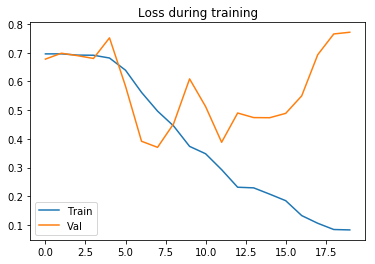

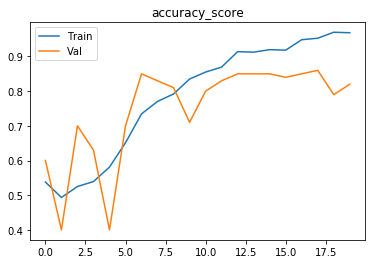

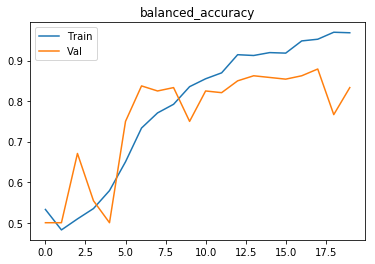

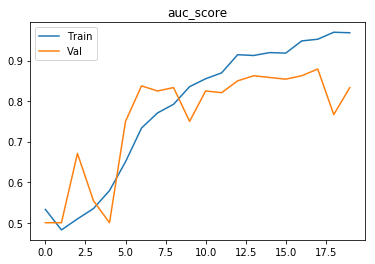

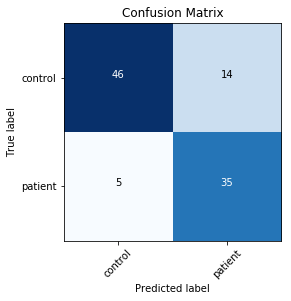

Starting trial 8
torch.Size([1, 96, 114, 96])
117


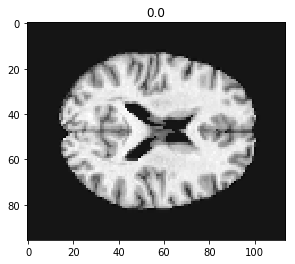

[0,    20] loss: 0.69474
[0,    40] loss: 0.70396
[0,    60] loss: 0.69520
[0,    80] loss: 0.69337
[0,   100] loss: 0.69625
Time elapsed: 0h:0m:57s
train accuracy_score: 49.50 %
train balanced_accuracy: 49.55 %
train auc_score: 49.55 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.725842
[1,    20] loss: 0.69600
[1,    40] loss: 0.69347
[1,    60] loss: 0.69222
[1,    80] loss: 0.69184
[1,   100] loss: 0.69969
Time elapsed: 0h:1m:57s
train accuracy_score: 53.80 %
train balanced_accuracy: 53.53 %
train auc_score: 53.53 %
val accuracy_score: 60.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.683122
[2,    20] loss: 0.69234
[2,    40] loss: 0.69469
[2,    60] loss: 0.69199
[2,    80] loss: 0.68997
[2,   100] loss: 0.69459
Time elapsed: 0h:2m:58s
train accuracy_score: 52.08 %
train balanced_accuracy: 51.90 %
train auc_score: 51.90 %
val accuracy_score: 61.00 %
val balanced_accuracy: 51.25 %
val auc_score: 51.25 %
Val l

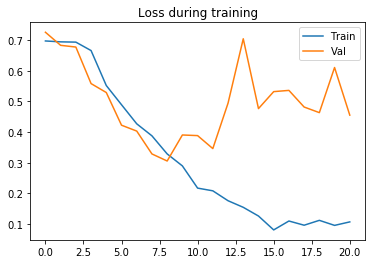

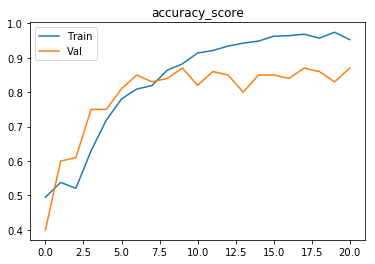

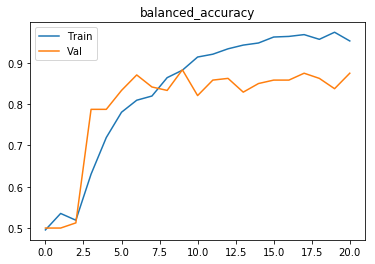

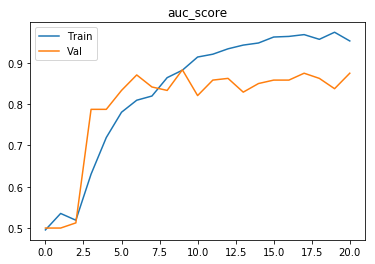

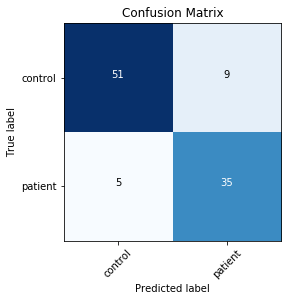

Starting trial 9
torch.Size([1, 96, 114, 96])
117


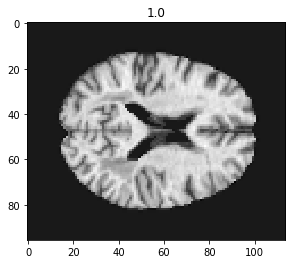

[0,    20] loss: 0.69523
[0,    40] loss: 0.68929
[0,    60] loss: 0.70015
[0,    80] loss: 0.69059
[0,   100] loss: 0.68990
Time elapsed: 0h:0m:57s
train accuracy_score: 53.08 %
train balanced_accuracy: 53.43 %
train auc_score: 53.43 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697351
[1,    20] loss: 0.69529
[1,    40] loss: 0.69691
[1,    60] loss: 0.69196
[1,    80] loss: 0.70117
[1,   100] loss: 0.69288
Time elapsed: 0h:1m:58s
train accuracy_score: 48.35 %
train balanced_accuracy: 49.22 %
train auc_score: 49.22 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729761
[2,    20] loss: 0.70134
[2,    40] loss: 0.69341
[2,    60] loss: 0.69315
[2,    80] loss: 0.69542
[2,   100] loss: 0.69439
Time elapsed: 0h:2m:59s
train accuracy_score: 49.93 %
train balanced_accuracy: 50.02 %
train auc_score: 50.02 %
val accuracy_score: 49.00 %
val balanced_accuracy: 57.08 %
val auc_score: 57.08 %
Val l

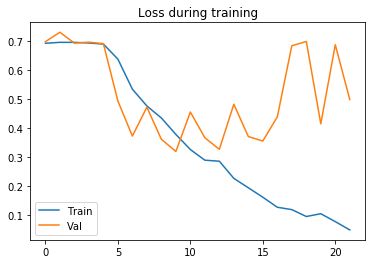

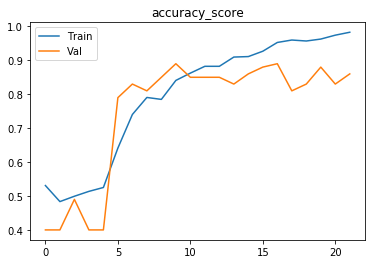

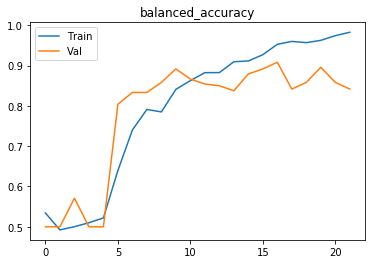

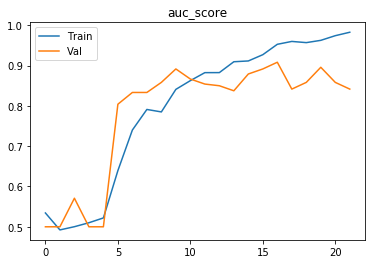

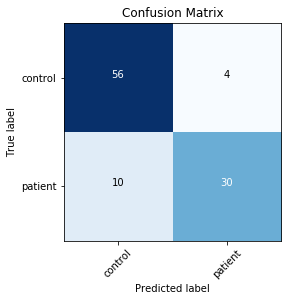

################################
################################
All accuracies: [0.8666666666666667, 0.9333333333333332, 0.8291666666666666, 0.8416666666666666, 0.7916666666666665, 0.875, 0.8833333333333333, 0.8333333333333335, 0.875, 0.8416666666666667]
0.8570833333333333
0.03651721435767582


In [26]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [27]:
print(np.mean(fold_metric))
print(np.std(fold_metric))

0.8570833333333333
0.03651721435767582


In [28]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [29]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=True
)

In [30]:
metrics = []
aucs = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=2)
    this_auc = auc(fpr, tpr)
    print(this_auc)
    aucs.append(this_auc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))
print("Balanced accuracy std {:.2f} %".format(np.std(metrics_df[0])*100))
print("AUC mean {}:.2f %".format(np.mean(aucs)))

Fold 0
0.8290034364261168
nan
Fold 1


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


0.843573883161512
nan
Fold 2
0.8387628865979382
nan
Fold 3
0.8657044673539518
nan
Fold 4
0.8796563573883162
nan
Fold 5
0.8581443298969071
nan
Fold 6
0.8387628865979382
nan
Fold 7
0.8745017182130583
nan
Fold 8
0.8654295532646048
nan
Fold 9
0.6793814432989691
nan
######## Final results ########
          0
0  0.829003
1  0.843574
2  0.838763
3  0.865704
4  0.879656
5  0.858144
6  0.838763
7  0.874502
8  0.865430
9  0.679381
Balanced accuracy mean 83.73 %
Balanced accuracy std 5.50 %
AUC mean nan:.2f %


In [ ]:
for i, m in enumerate(models):
    print(i)
    for param in m.parameters():
        print(param.grad.norm(2))

In [ ]:
all_weight_norms = {}
all_bias_norms = {}
for i, m in enumerate(models):
    bias_norms = {}
    weight_norms = {}
    print(i)
    for name, param in m.named_parameters():
        #norms.append(param.grad.norm(2))
        norm = param.grad.norm(2)
        if name.endswith("bias"):
            name = name.replace(".bias", "")
            bias_norms["layer_{}".format(name)] = norm
        elif name.endswith("weight"):
            name = name.replace(".weight", "")
            weight_norms["layer_{}".format(name)] = norm
    all_weight_norms["fold_{}".format(i)] = weight_norms
    all_bias_norms["fold_{}".format(i)] = bias_norms

In [ ]:
list(metrics_df["balanced_accuracy"])

In [ ]:
num_cols = 2
num_rows = 4
plt.figure()
c = 1
r = 1

plt.figure(figsize=(12, 24))
plt.subplots_adjust(hspace=0.9, wspace=0.2)
for f in range(len(models)):
    plt.subplot(num_rows, num_cols, f+1)
    plt.plot(*zip(*sorted(all_weight_norms["fold_{}".format(f)].items())))
    plt.plot(*zip(*sorted(all_bias_norms["fold_{}".format(f)].items())))
    plt.legend(["Weights", "Biases"])
    plt.title("Fold {} Test balanced acc {:.2f}".format(f, metrics_df["balanced_accuracy"][f]))
    plt.xticks(rotation=90)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    c += 1
plt.show()
    